# Alphas, betas and regressions refactoring with classes

* stream_05.py

En 07 vimos $r_{a} = \alpha + \beta r_M + \varepsilon$ y ahora vamos hacer esta regresion con respecto al mercado. En este caso para $r_M$ vamos a usar acciones europeas pero podrçia ser cualquier otros mercados.

Vamos hacer esta regresión lineal y calcular el beta que ya aprendimos a calcularlo utilizando varianzas y covarianzas:

$\beta = \frac{Cov(r_a, r_M)}{Var(r_M)} = \rho(r_a, r_M)\frac{\sigma_{A}}{\sigma_{M}}$

pero ahora lo calcularemos tbn con la regresión. Tengo dos serie de tiempo y simplemente voy a tomar la regresion lineal... y veremos que será exactamente igual que calcular $\beta$.

In [1]:
import numpy as np
import pandas as pd
import scipy
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis, chi2, linregress

# import our own files an reload
import stream_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_classes_refactoring2)



# BBVA.MC vs ^STOXX
ric = "BBVA.MC"        # MT.SA, BBVA.MC, REP.MC, VWS.CO, ^VIX
benchmark = "^STOXX"  # STOXX50E, ^STOXX, ^S&P500, ^NASDAQ, ^FCHI, ^GDAXI
file_extension = "csv"
nb_decimals = 4

# ric = r_a and benchmark = r_m
x1, str1, t1 = stream_functions.load_time_series(ric)
x2, str2, t2 = stream_functions.load_time_series(benchmark)

* **ric** = rendimiento de mi activo = $r_a$ = y
* **benchmark** = rendimiento del mercado =  $r_M$ = x

In [2]:
print(len(x1))
print(len(x2))

1278
1253


La serie de tiempo de mi activo **ArcelorMittal (MT.AS)** tiene diferente longitud que la del mercado **STXE 600 PR.EUR (^STOXX)**. Debemos sincronizarlos:
* voy a crear listas de los timestamps
* luego tomaré la intersección, conservo los que están en los dos grupos.

In [3]:
# aquí tengo mis fechas
print(t1.head(1))
print(t2.head(1))

        date  close  close_previous  return_close
0 2015-07-02   8.84           8.963     -0.013723
        date       close  close_previous  return_close
0 2015-07-02  385.459991      387.070007     -0.004159


In [4]:
# sinchronize timestamps
timestamps1 = list(t1['date'].values) # .values lo convierte en array
timestamps2 = list(t2['date'].values)
timestamps = list(set(timestamps1) & set(timestamps2))

Una vez que tengo el conjunto de fechas en **timestamps** voy a sincronizar mis datos:

In [5]:
# synchronised time series for x1 (ric)
t1_sync = t1[t1['date'].isin(timestamps)]
t1_sync.sort_values(by='date', ascending=True)
t1_sync = t1_sync.reset_index(drop=True)

# synchronised time series for x2 (benchmark)
t2_sync = t2[t2['date'].isin(timestamps)]
t2_sync.sort_values(by='date', ascending=True)
t2_sync = t2_sync.reset_index(drop=True)

Voy a crear un atabla para guardar lo que devuelve ric and benchmark

In [6]:
# table of returns for ric and benchmark
t = pd.DataFrame()
t['date'] = t1_sync.date
t['price_1'] = t1_sync.close
t['price_2'] = t2_sync.close
t['return_1'] = t1_sync.return_close
t['return_2'] = t2_sync.return_close

In [7]:
t.head()

,date,price_1,price_2,return_1,return_2
0,2015-07-02,8.840,385.459991,-0.013723,-0.004159
1,2015-07-03,8.837,383.420013,-0.000339,-0.005292
2,2015-07-06,8.550,378.679993,-0.032477,-0.012362
3,2015-07-07,8.352,372.739990,-0.023158,-0.015686
4,2015-07-08,8.460,372.880005,0.012931,0.000376


---

$r_{a} = \alpha + \beta r_M + \varepsilon$

* $r_a$ = **price_1**
* $r_M$ = **price_2**

Yo voy hacer la regresion lineal del 
* **return_1** con respecto $r_a$
* **return_2** con respecto $r_M$

In [8]:
# compute vectors of return
y = t['return_1'].values
x = t['return_2'].values

Regresion lineal

* https://docs.scipy.org/doc/scipy-1.6.2/reference/generated/scipy.stats.linregress.html


In [9]:
slope, intercep, r_values, p_values, std_err = linregress(x, y)

slope = np.round(slope, nb_decimals)
intercept = np.round(intercep, nb_decimals)
p_values = np.round(p_values, nb_decimals)
r_values = np.round(r_values, nb_decimals)
r_squared = np.round(r_values**2, nb_decimals)

# Si el `p_value < 0.05` rechazamos la hipótesis nula.
null_hypothesis = p_values > 0.05

# predictor 
predictor_linreg = slope*x + intercept

* **slope** (pendiente) = $\beta$
* **intercep** (ordenada al origen) = $\alpha$
* **r_value** es la correlación.
* **r_squared** * 100 el porcentaje de toda la información vista como la varianza del modelo, la recupera la regresión lineal. Es decir si $R^2 = .58$ significa que $\alpha + \beta r_M$ recupera el 58% y el error $\varepsilon$ tiene el 42%.
* La **hipótesis nula** de este caso es que tanto alpha como beta son 0. Que no hay regresión lineal. 
* Mi **predictor_linreg** de la regresión lineal va a ser $r_{a} = \alpha + \beta r_M$, osea que voy a aproximar mi rendimiento como $\alpha + \beta r_M$. Con esto podré comparar mi verdadera $y$ con el predictor.

In [10]:
print(p_values)

0.0


Como el p_value es muy pequeño rechazamos la hipótesis nula, los alpha y beta que tengo nos dice que son estadísticamente significativos.

In [11]:
print(null_hypothesis)

False


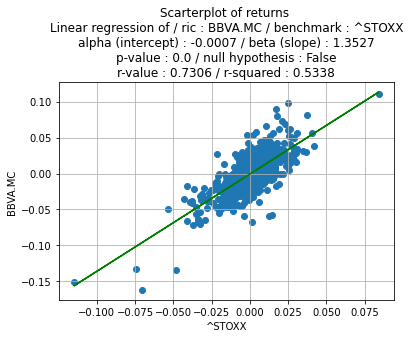

In [12]:
# scatterplot of returns
str_title = "Scarterplot of returns " + "\n"\
    + "Linear regression of / ric : " + ric\
    + " / benchmark : " + benchmark + "\n"\
    + "alpha (intercept) : " + str(intercept)\
    + " / beta (slope) : " + str(slope) + "\n"\
    + "p-value : " + str(p_values)\
    + " / null hypothesis : " + str(null_hypothesis) + "\n"\
    + "r-value : " + str(r_values)\
    + " / r-squared : " + str(r_squared)

plt.figure()
plt.title(str_title)
plt.scatter(x,y)
plt.plot(x, predictor_linreg, color="green")
plt.ylabel(ric)
plt.xlabel(benchmark)
plt.grid()
plt.show()

Esta regresión lineal en verde si tiene buena cara, entonces cuando uno se pregunta si debería considerar la *tasa libre de riesgo* y seguir el modelo como tal, yo simplemente dije, voy a suponer hacer las matemáticas más simples que pueda $r_{a} = \alpha + \beta r_M + \varepsilon$ y cunado optengo esa linea verde digo ok, perfecto. Entonces bajo esa perspectiva, como tiene una buena $R^2$ el modelo no estám mal, entonces voy a suponer que la **tasa libre de riesgo** es igual a cero o que no existe no es un mal modelo por lo que se muestra.

**MONTO MI ESTRUCTURA**  y pruebo con otros activos:

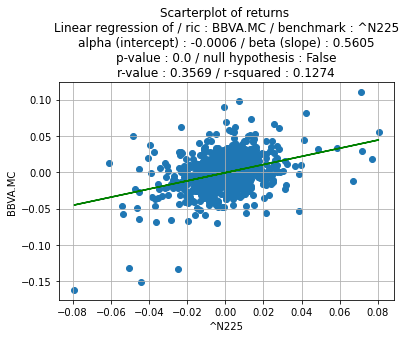

In [19]:

def camp(ric, benchmark, file_extension, nb_decimals):

    # ric = r_a and benchmark = r_m
    x1, str1, t1 = stream_functions.load_time_series(ric)
    x2, str2, t2 = stream_functions.load_time_series(benchmark)

    # sinchronize timestamps
    timestamps1 = list(t1['date'].values) # .values lo convierte en array
    timestamps2 = list(t2['date'].values)
    timestamps = list(set(timestamps1) & set(timestamps2))

    # synchronised time series for x1 (ric)
    t1_sync = t1[t1['date'].isin(timestamps)]
    t1_sync.sort_values(by='date', ascending=True)
    t1_sync = t1_sync.reset_index(drop=True)

    # synchronised time series for x2 (benchmark)
    t2_sync = t2[t2['date'].isin(timestamps)]
    t2_sync.sort_values(by='date', ascending=True)
    t2_sync = t2_sync.reset_index(drop=True)

    # table of returns for ric and benchmark
    t = pd.DataFrame()
    t['date'] = t1_sync.date
    t['price_1'] = t1_sync.close
    t['price_2'] = t2_sync.close
    t['return_1'] = t1_sync.return_close
    t['return_2'] = t2_sync.return_close

    # compute vectors of return
    y = t['return_1'].values
    x = t['return_2'].values

    # linal regression
    slope, intercep, r_values, p_values, std_err = linregress(x, y)

    slope = np.round(slope, nb_decimals)
    intercept = np.round(intercep, nb_decimals)
    p_values = np.round(p_values, nb_decimals)
    r_values = np.round(r_values, nb_decimals)
    r_squared = np.round(r_values**2, nb_decimals)

    # Si el `p_value < 0.05` rechazamos la hipótesis nula.
    null_hypothesis = p_values > 0.05

    # predictor 
    predictor_linreg = slope*x + intercept

    # scatterplot of returns
    str_title = "Scarterplot of returns " + "\n"\
        + "Linear regression of / ric : " + ric\
        + " / benchmark : " + benchmark + "\n"\
        + "alpha (intercept) : " + str(intercept)\
        + " / beta (slope) : " + str(slope) + "\n"\
        + "p-value : " + str(p_values)\
        + " / null hypothesis : " + str(null_hypothesis) + "\n"\
        + "r-value : " + str(r_values)\
        + " / r-squared : " + str(r_squared)

    plt.figure()
    plt.title(str_title)
    plt.scatter(x,y)
    plt.plot(x, predictor_linreg, color="green")
    plt.ylabel(ric)
    plt.xlabel(benchmark)
    plt.grid()
    plt.show()

if __name__ == "__main__":
    # BBVA.MC vs Nikkei 225 (^N225)
    ric = "BBVA.MC"         # SAN MT.SA, BBVA.MC, REP.MC, VWS.CO, ^VIX
    benchmark = "^N225"  # ^STOXX50E, ^STOXX, ^S&P500, ^NASDAQ, ^FCHI, ^GDAXI
    file_extension = "csv"
    nb_decimals = 4
    camp(ric, benchmark, file_extension, nb_decimals)

La manera de entender el "goodnes of fit" (la bondad de ajuste) es
* BBVA.MC vs ^STOXX $R^2 = 45\%$ 
> En este caso puedo representarlo por una recta.
* BBVA.MC vs Nikkei 225 (^N225) $R^2 = 10\%$
> En este caso no puedo representarlo por una recta.

Yo he pasado de del 45% al 10%, obviamente porque el indice niquei es el mercado japones y el Eurostoxx es Europeo y estoy jugando con Bbva que es acción Europea.

¿Qué pasa si lo hacemos respecto al índice mexicano? Qué pasa si yo quiero explicar el Bbva a través de las fluctuaciones del peso mexicano.

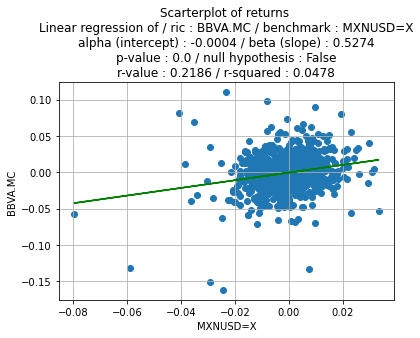

In [20]:
# BBVA.MC vs MXN/USD (MXNUSD=X)
ric = "BBVA.MC"         # SAN MT.SA, BBVA.MC, REP.MC, VWS.CO, ^VIX
benchmark = "MXNUSD=X"  # ^STOXX50E, ^STOXX, ^S&P500, ^NASDAQ, ^FCHI, ^GDAXI
file_extension = "csv"
nb_decimals = 4
camp(ric, benchmark, file_extension, nb_decimals)

Tenemos un 3% de $R^2$ y la regresión es casi plana, todavía la hipótesis es falsa porque tengo mucho puntos (1200) entonces mi intervalo de confianza es muy pequeño.  Pasamos de explicar del 45% de mi información vista como varianza, al 10% y ahora al 3%.

**¿Por qué con el eurostock50 (^STOXX50E) tengo una beta de 1.272 y explicación del 51% ($R^2$)  
y con ^STOXX tengo una beta de 1.36 y explicación del 45%?  
¿por qué en el ^STOXX50E está más compacto?**

Porque en ^STOXX50E el Bbva es una de las 50 empresas y en el ^STOXX es una de entre las 600 empresas que cotiza, entonces 1/50 es más grande que 1/600. El $R^2$ nos explica que tanto varían los puntos respecto al recta, de toda la volatilidad sólo estoy esplicado esto a través de la recta.

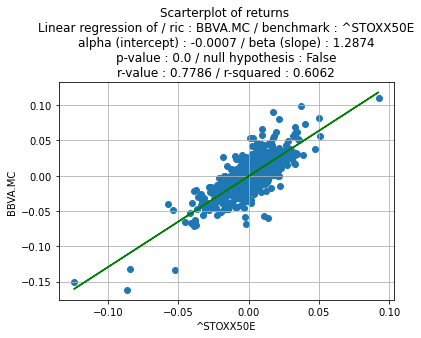

In [21]:
ric = "BBVA.MC"         
benchmark = "^STOXX50E" 
camp(ric, benchmark, file_extension, nb_decimals)

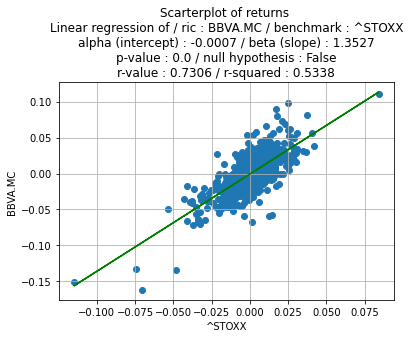

In [22]:
ric = "BBVA.MC"         
benchmark = "^STOXX"  
camp(ric, benchmark, file_extension, nb_decimals)

**COMPAREMOS EL VIX con S&P500**

El vix es el valor de la volatilidad del S&P. Cuando la volatilidad explota, explota más cuando los precios caen que cuando los precios suben.   Además el Vix por el efecto de palanca: 
* cuando vemos **beta: 1.3607** significa que si el `STOXX sube el 1%`entonces `BBVA va a subir 1.36%`

entonces si el S&P500 cae 10% ¿Qué esperamos del vix?

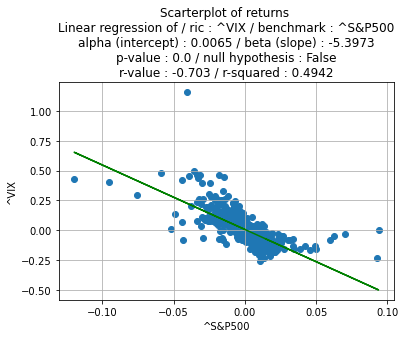

In [23]:
ric = "^VIX"         
benchmark = "^S&P500"  
camp(ric, benchmark, file_extension, nb_decimals)

El vix, como es efecto de palanca, va a ser |beta| > 1 y beta va a ser negativo porque cuando caen los precios la volatilidad explota. Entonces cuando en general se diga que los betas son positivos, aquí vemos un activo cuyo beta vs S&P500 es muy negativo, es el efecto de palanca, es decir que si car el **S&P500** un 10% de acuerdo el modelo el **VIX** va a subir 54%. Además el modelo explica el 49%.

**VEAMOS CUÁL ES LA CORRELACIÓN DE EU RESPECTO EEUU**  

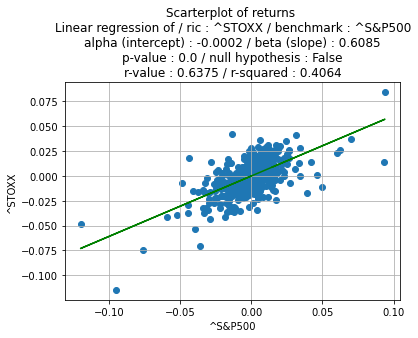

In [24]:
ric = "^STOXX"         
benchmark = "^S&P500"  
camp(ric, benchmark, file_extension, nb_decimals)

No está tan mal, los mercados suben y bajan más o menos juntos.

**TELUS International (Cda) Inc. (TIXT) VS NASDAQ**

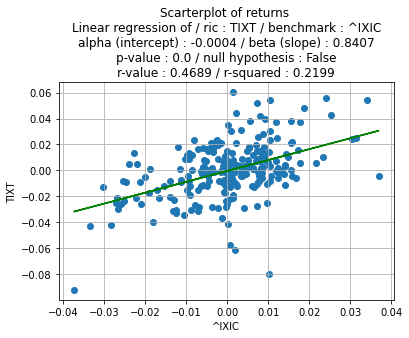

In [27]:
ric = "TIXT"         
benchmark = "^IXIC" # ^NASDAQ == ^IXIC
camp(ric, benchmark, file_extension, nb_decimals)

Real returns TIXT | size 236
mean: -0.00018 | std : 0.02137 | skewness : -0.32147 | kurtosis : 2.156 | median : 0.0 | x_sharpe ratio :-0.1312
 VaR 95% : -0.0314 | CVaR 95% : -0.04959 | Jarque-Bera : 49.7733 | p_value : 0.0 | is normal :False



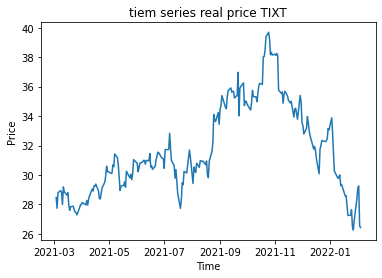

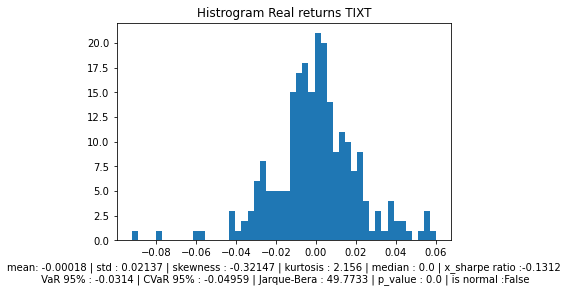

In [28]:
import importlib
import stream_functions
import stream_classes_refactoring2
importlib.reload(stream_functions)  # aveces no importa bien


ric = "TIXT"
x, x_str, t = stream_functions.load_time_series(ric)
z = stream_classes_refactoring2.jarque_bera_test(x, x_str)
z.compute()
print(z)

# genero plots de los métodos
stream_functions.plot_time_series_price(ric, t)
stream_functions.plot_histogram(x, x_str, z.plot_str(), bins=50)